<a href="https://colab.research.google.com/github/ssujinK/bayesian/blob/master/190412_Bayesian_with_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CH3. MCMC 블랙박스 열기

##MCMC란?


*   베이지안 추론은 frequentist 추론과 다르게 모수가 확률분포를 가지므로 사전분포와 가능도함수를 결합한 사후분포를 통해 추론하게 됨
*   알기 어려운 사후분포를 근사적으로 어림하기 위해 MCMC로 사후분포의 표본을 sampling하여 근사적인 추론을 할 수 있음



## 3.1. 베이지안 지형


1.   모수가 N개인 베이지안 추론 문제에서 N차원 공간을 형성함
2.   N차원 공간에 사전확률분포를 그림
3.   데이터를 결합하여 사후확률분포를 얻음   

---




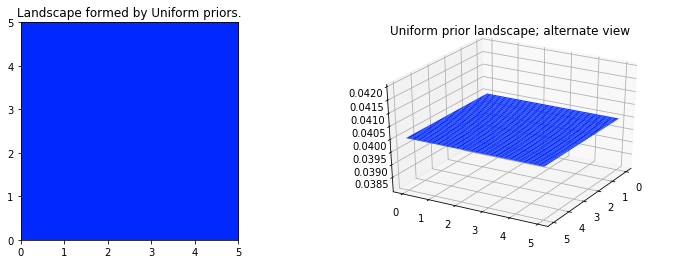

In [1]:
## ex. Uniform prior
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");

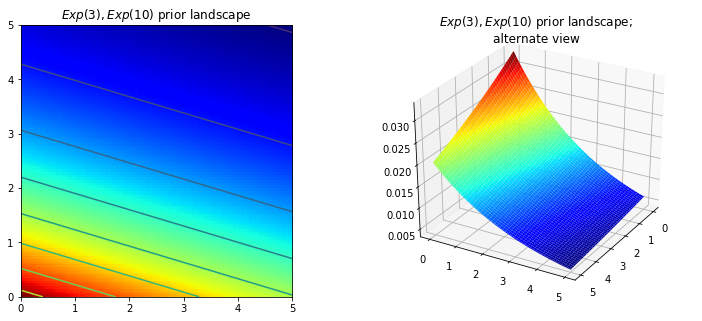

In [2]:
## ex. Exponential prior
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");

>　
>　
>　
>　
---
>　
>　
>　
>　

In [19]:
# create the observed data

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = %d):" % N, data)

# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional,sample size = 1): [[1 3]]


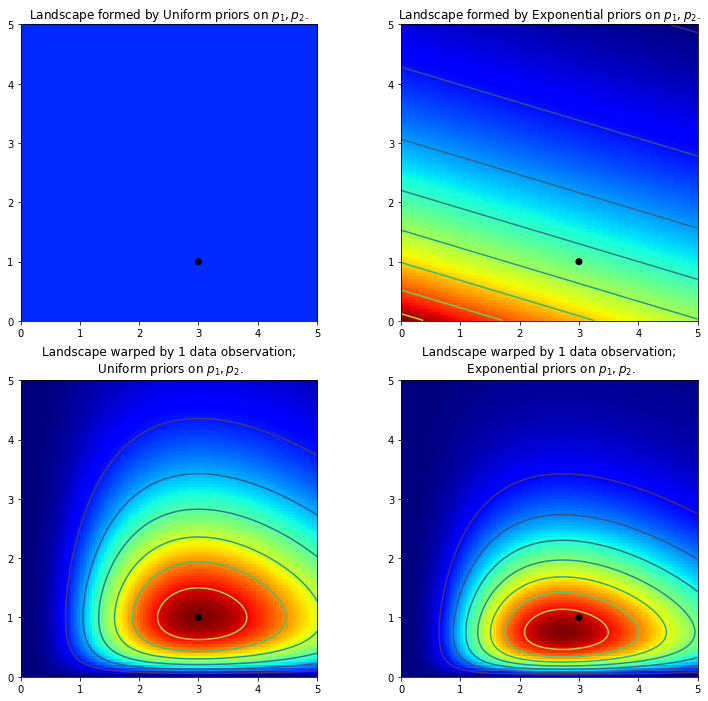

In [20]:
figsize(12.5, 12)
# matplotlib heavy lifting below, beware!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);

*   Likelihood: N=1이고 *λ*가 1, 3인 포아송분포
*   같은 관측 데이터일지라도 다른 사전분포를 적용하면 서로 다른 사후분포를 얻음

     → 사후분포는 사전분포의 모양의 영향을 받음



In [25]:
# create the observed data

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 100

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = %d):" % N, data)

# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional,sample size = 100): [[0 3]
 [1 4]
 [0 7]
 [0 5]
 [0 5]
 [1 3]
 [2 1]
 [2 5]
 [2 2]
 [1 2]
 [1 2]
 [0 3]
 [1 2]
 [0 2]
 [1 1]
 [0 2]
 [2 2]
 [0 1]
 [1 7]
 [1 3]
 [1 6]
 [0 4]
 [3 0]
 [0 1]
 [2 4]
 [2 1]
 [2 3]
 [1 5]
 [1 3]
 [1 1]
 [1 1]
 [3 2]
 [1 2]
 [1 4]
 [1 3]
 [0 3]
 [0 5]
 [0 8]
 [0 3]
 [3 1]
 [0 3]
 [0 4]
 [0 2]
 [2 4]
 [1 1]
 [1 4]
 [2 3]
 [0 4]
 [0 2]
 [1 3]
 [5 2]
 [1 3]
 [1 2]
 [1 3]
 [1 2]
 [1 3]
 [0 4]
 [0 3]
 [0 6]
 [3 1]
 [1 9]
 [2 3]
 [1 6]
 [1 4]
 [2 3]
 [1 4]
 [1 3]
 [3 1]
 [1 3]
 [1 3]
 [1 0]
 [0 3]
 [4 2]
 [1 3]
 [1 2]
 [3 2]
 [2 3]
 [0 4]
 [0 3]
 [1 3]
 [3 1]
 [1 3]
 [2 2]
 [1 2]
 [0 4]
 [1 6]
 [0 2]
 [3 4]
 [2 4]
 [0 2]
 [2 3]
 [1 1]
 [1 2]
 [1 5]
 [1 3]
 [0 1]
 [2 2]
 [0 3]
 [0 4]
 [2 1]]


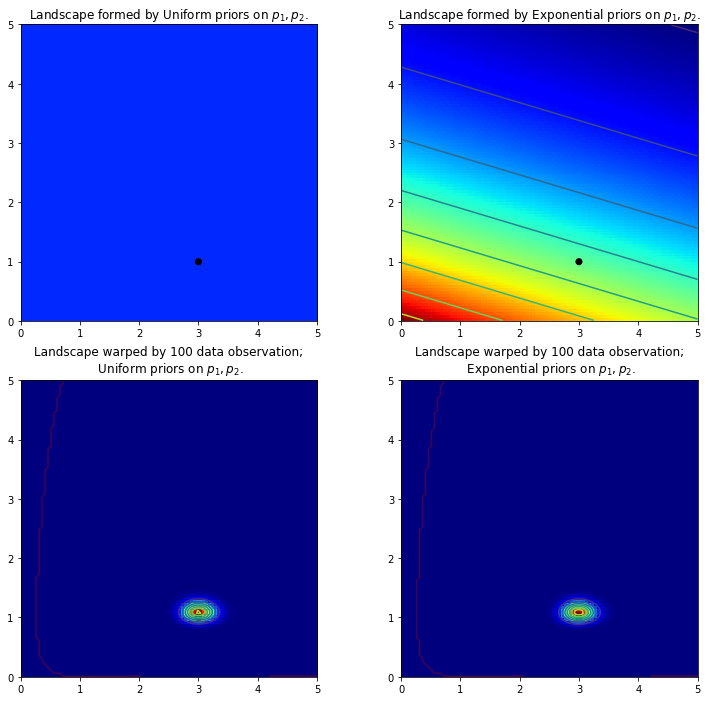

In [26]:
figsize(12.5, 12)
# matplotlib heavy lifting below, beware!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);



*   Likelihood: N=100,  λ가 1, 3인 포아송분포
*   두 사후분포 모두 (1, 3)에 집중되어 있음

     → 표본크기가 증가한면 사후분포의 영향이 작아짐




---
>　
>　
>　

##3.1.1. MCMC를 사용하여 지형 탐색하기



*   산 = 사후분포, 조약돌 = sample
*   내가 발견한 조약돌이 내가 찾으려는 산에서 나온 돌인지?
*   조약돌이 많으면 그 산의 지형 파악에 더 용이할 것

> → 사후분포 자체를 얻는 것이 아닌 사후분포의 표본을 sampling하여 실제와 가까운 사후분포를 얻는 것


##3.1.2. MCMC 수행 알고리즘


1.   현재 위치에서 시작
2.   새로 이동할 위치 조사(주변의 조약돌 조사)
3.   데이터와 사전확률분포에 따른 위치를 바탕으로 새로운 위치를 수용하거나 기각(조약돌이 그 산에서 나올 가능성을 조사)
4.   수용한다면 새로운 위치로 이동하고 반복, 그렇지 않으면 이동하지 않고 반복

　
 　

*   이 방법으로 사후분포가 존재하는 곳으로 이동하고, 이동 중 표본을 수집하게 됨
*   이동 중 사후분포에 도달하게 되면 그때부턴 사후확률 분포에 속할 가능성이 높으므로 표본을 쉽게 모을 수 있음
*   초기값이 사후분포에 속할 가능성이 낮다면 좀 더 나은 위치로 이동하며 점점 사후분포에 가까워지므로, 알고리즘 초반 부분은 반영하지 않음(burn-in period)



##3.1.3. 사후확률분포에 대한 다른 접근법


*   라플라스 근사법
*   변분 베이즈(variational Bayes)




##.3.1.4. 예제: 혼합모델을 사용한 비지도 클러스터링

In [91]:
figsize(12.5, 4)
data = np.loadtxt("mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")

ValueError: ignored


Bimodal 형태로 이 데이터 셋은 클러스터가 두 개 있을 수 있음

### 알고리즘
1.   각 데이터 포인트에 대해 특정 확률(p)을 가진 클러스터 0이나 클러스터 1를 선택
2.   클러스터의 모수가 각각 (μ0, σ0), (μ1, σ1)인 정규분포에서 sampling



---


*   클러스터 0에 해당하는 정규분포를 Norm0, 클러스터 1의 정규분포를 Norm1이라고 함
*   데이터 포인트는 Norm0이나 Norm1에서 나올 수 있는데, 데이터 포인트가 p의 확률을 가진 Norm0에 할당되어 있다고 가정
*   클러스터 0에 어떤 확률이 부여될지 모르므로 p~unif(0,1)
*   





In [101]:
!pip install pymc3
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    assignment = pm.Categorical("assignment", T.stack([p1, 1-p1]), 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.50:
[1]


In [102]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:4], "...")
print("Assigned center: ", center_i.tag.test_value[:4], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:4])

Random assignments:  [1] ...
Assigned center:  [190.] ...
Assigned standard deviation:  [50.]


In [106]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

TypeError: ignored

NameError: ignored

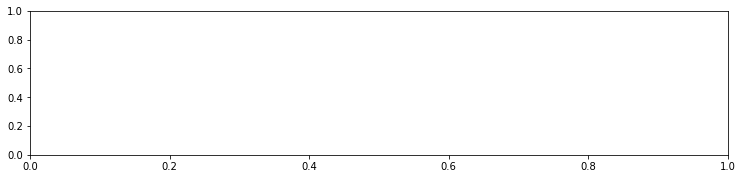

In [100]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();